In [1]:
import pandas as pd
i2g_df = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df.csv')

In [ ]:
from Bio import Entrez

Entrez.email = "gl1768@nyu.edu"

def entrez_to_gene_name(entrez_id):
    try:
        handle = Entrez.esummary(db="gene", id=str(entrez_id))
        record = Entrez.read(handle)
        handle.close()
        if record:
            print(record)
            return record[0].get("Name", "Unknown")
        else:
            return "Unknown"
    except Exception as e:
        return "Unknown"

i2g_df = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df.csv', header=None, names=["Node_ID", "Entrez_ID"])

i2g_df['Gene_Name'] = i2g_df['Entrez_ID'].apply(entrez_to_gene_name)

print(i2g_df.head())

i2g_df.to_csv('p/Users/martinli/Desktop/SZ/i2g_df_wg.csv', index=False)

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
i2g_df = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df.csv', header=None, names=["Node_ID", "Entrez_ID"])
ppionly_uc_newresults = pd.read_csv('/Users/martinli/Desktop/SZ/ppionly_uc_newresults.csv')
edge_uc_3_df = pd.read_csv('/Users/martinli/Downloads/edge_uc_3.txt', sep=" ", header=None, names=["From", "To"])
merged_df = pd.merge(ppionly_uc_newresults, i2g_df, left_on='entrez id', right_on='Entrez_ID')

In [6]:
merged_df

,node id,probability,entrez id,Node_ID,Entrez_ID
0,18534,1.000000,100506127,18534.0,100506127
1,18228,0.999176,114926,18228.0,114926
2,17125,0.994963,100861412,17125.0,100861412
3,9402,0.965518,10019,9402.0,10019
4,17437,0.963912,150223,17437.0,150223
...,...,...,...,...,...
397,10655,0.101744,6788,10655.0,6788
398,9478,0.101541,1512,9478.0,1512
399,3028,0.101527,3569,3028.0,3569
400,10014,0.101261,10068,10014.0,10068


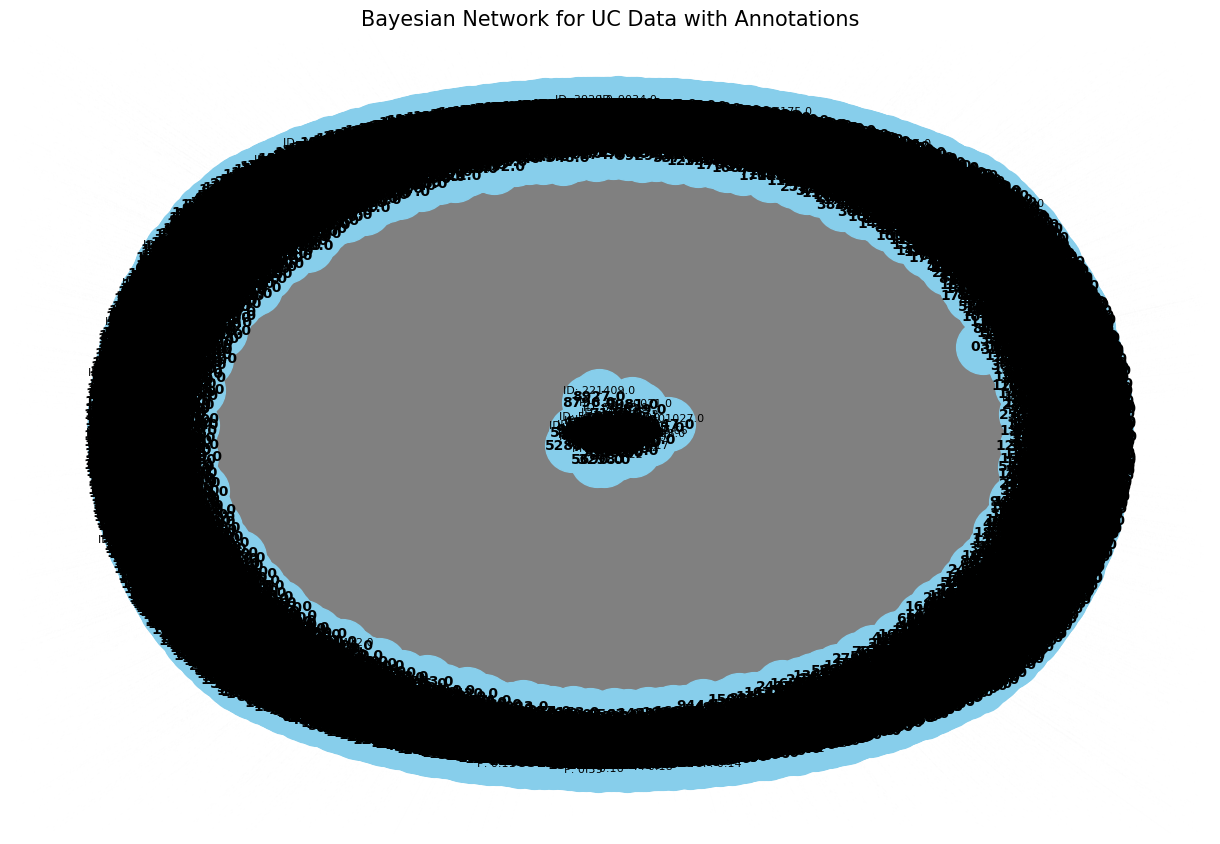

In [3]:
G = nx.DiGraph()
edges = [(row['From'], row['To']) for index, row in edge_uc_3_df.iterrows()]
G.add_edges_from(edges)

# Entrez ID 概率值
for index, row in merged_df.iterrows():
    node = row['node id']
    if node in G.nodes:
        G.nodes[node]['Entrez_ID'] = row['entrez id']
        G.nodes[node]['Probability'] = row['probability']

plt.figure(figsize=(12, 8))
# 节点位置
pos = nx.spring_layout(G, seed=42)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', font_size=10, font_weight='bold')
node_labels = {node: f"ID: {G.nodes[node]['Entrez_ID']}\nP: {G.nodes[node]['Probability']:.2f}" for node in G.nodes if 'Entrez_ID' in G.nodes[node]}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

plt.title("Bayesian Network for UC Data with Annotations", fontsize=15)
plt.show()

In [4]:
# 中心性指标
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
for node in G.nodes:
    G.nodes[node]['Degree_Centrality'] = degree_centrality[node]
    G.nodes[node]['Betweenness_Centrality'] = betweenness_centrality[node]

top_nodes_by_degree = sorted(G.nodes(data=True), key=lambda x: x[1]['Degree_Centrality'], reverse=True)[:5]
print("Top nodes by Degree Centrality:")
for node, data in top_nodes_by_degree:
    print(f"Node: {node}, Degree Centrality: {data['Degree_Centrality']}")

top_nodes_by_betweenness = sorted(G.nodes(data=True), key=lambda x: x[1]['Betweenness_Centrality'], reverse=True)[:5]
print("\nTop nodes by Betweenness Centrality:")
for node, data in top_nodes_by_betweenness:
    print(f"Node: {node}, Betweenness Centrality: {data['Betweenness_Centrality']}")

Top nodes by Degree Centrality:
Node: 1293.0, Degree Centrality: 0.38492860010322877
Node: 1405.0, Degree Centrality: 0.31387279922004935
Node: 1710.0, Degree Centrality: 0.2886964500774216
Node: 723.0, Degree Centrality: 0.2807248953375007
Node: 3028.0, Degree Centrality: 0.25187819005562884

Top nodes by Betweenness Centrality:
Node: 1293.0, Betweenness Centrality: 0.0011378629308028546
Node: 1405.0, Betweenness Centrality: 0.0007054744745814549
Node: 1710.0, Betweenness Centrality: 0.0006880395718963741
Node: 723.0, Betweenness Centrality: 0.000547603614063983
Node: 5605.0, Betweenness Centrality: 0.0004924885666017238


In [5]:
# 显示概率值最高的节点
top_nodes_by_probability = sorted(G.nodes(data=True), key=lambda x: x[1].get('Probability', 0), reverse=True)[:5]
print("\nTop nodes by Probability:")
for node, data in top_nodes_by_probability:
    print(f"Node: {node}, Probability: {data['Probability']:.2f}")


Top nodes by Probability:
Node: 18228.0, Probability: 1.00
Node: 17125.0, Probability: 0.99
Node: 9402.0, Probability: 0.97
Node: 17437.0, Probability: 0.96
Node: 11504.0, Probability: 0.96


In [ ]:
# 绘制带高概率节点注释的图
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # 节点位置
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', font_size=10, font_weight='bold')

high_prob_nodes = [node for node, data in top_nodes_by_probability]
nx.draw_networkx_nodes(G, pos, nodelist=high_prob_nodes, node_color='red')

# 添加高概率节点的标签
node_labels = {node: f"ID: {G.nodes[node]['Entrez_ID']}\nP: {G.nodes[node]['Probability']:.2f}" for node in high_prob_nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

plt.title("Bayesian Network for UC Data with High Probability Nodes", fontsize=15)
plt.show()

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

i2g_df = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df.csv', header=None, names=["Node_ID", "Entrez_ID"])
new_uc_results = pd.read_csv('/Users/martinli/Desktop/SZ/new_uc_results.csv', header=None, names=["Node_ID", "Probability"])
edge_uc_3_df = pd.read_csv('/Users/martinli/Desktop/SZ/edge_uc_3.txt', sep=" ", header=None, names=["From", "To"])
merged_df = pd.merge(new_uc_results, i2g_df, left_on='Node_ID', right_on='Node_ID')

In [8]:
merged_df.head()

,Node_ID,Probability,Entrez_ID
0,NaN,0.000000,0
1,0.0,0.006979,381
2,1.0,0.005006,805
3,2.0,0.001635,23229
4,3.0,0.011758,2081


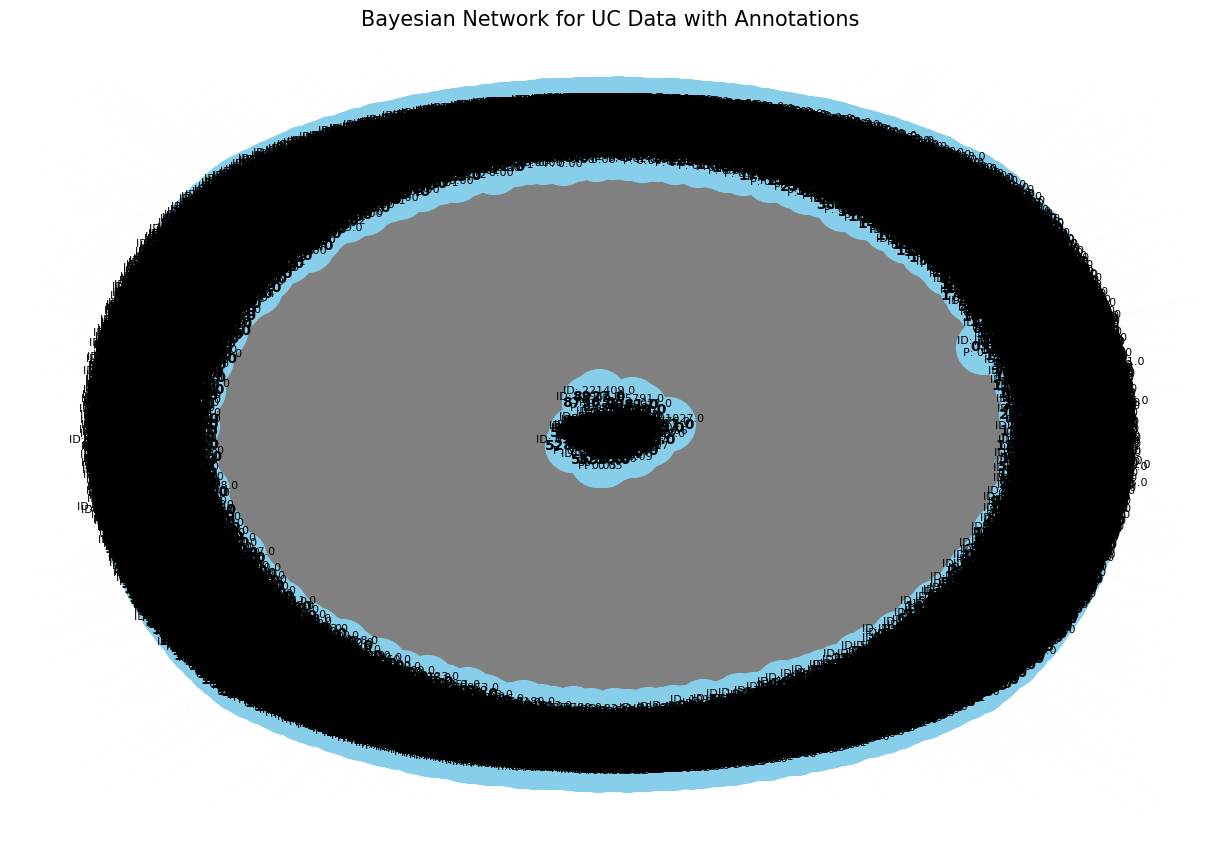

In [10]:
# 创建有向图
G = nx.DiGraph()

# 添加边
edges = [(row['From'], row['To']) for index, row in edge_uc_3_df.iterrows()]
G.add_edges_from(edges)

for index, row in merged_df.iterrows():
    node = row['Node_ID']
    if node in G.nodes:
        G.nodes[node]['Entrez_ID'] = row['Entrez_ID']
        G.nodes[node]['Probability'] = row['Probability']

        
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # 节点位置
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', font_size=10, font_weight='bold')
node_labels = {node: f"ID: {G.nodes[node]['Entrez_ID']}\nP: {G.nodes[node]['Probability']:.2f}" for node in G.nodes if 'Entrez_ID' in G.nodes[node]}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

plt.title("Bayesian Network for UC Data with Annotations", fontsize=15)
plt.show()

In [11]:
# 计算中心性指标
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# 添加中心性到节点
for node in G.nodes:
    G.nodes[node]['Degree_Centrality'] = degree_centrality[node]
    G.nodes[node]['Betweenness_Centrality'] = betweenness_centrality[node]

# degree最高的节点
top_nodes_by_degree = sorted(G.nodes(data=True), key=lambda x: x[1]['Degree_Centrality'], reverse=True)[:5]
print("Top nodes by Degree Centrality:")
for node, data in top_nodes_by_degree:
    print(f"Node: {node}, Degree Centrality: {data['Degree_Centrality']}")

# betweenness最高的节点
top_nodes_by_betweenness = sorted(G.nodes(data=True), key=lambda x: x[1]['Betweenness_Centrality'], reverse=True)[:5]
print("\nTop nodes by Betweenness Centrality:")
for node, data in top_nodes_by_betweenness:
    print(f"Node: {node}, Betweenness Centrality: {data['Betweenness_Centrality']}")

Top nodes by Degree Centrality:
Node: 1293.0, Degree Centrality: 0.38492860010322877
Node: 1405.0, Degree Centrality: 0.31387279922004935
Node: 1710.0, Degree Centrality: 0.2886964500774216
Node: 723.0, Degree Centrality: 0.2807248953375007
Node: 3028.0, Degree Centrality: 0.25187819005562884

Top nodes by Betweenness Centrality:
Node: 1293.0, Betweenness Centrality: 0.0011378629308028546
Node: 1405.0, Betweenness Centrality: 0.0007054744745814549
Node: 1710.0, Betweenness Centrality: 0.0006880395718963741
Node: 723.0, Betweenness Centrality: 0.000547603614063983
Node: 5605.0, Betweenness Centrality: 0.0004924885666017238


In [12]:
# prob最高的节点
top_nodes_by_probability = sorted(G.nodes(data=True), key=lambda x: x[1].get('Probability', 0), reverse=True)[:5]
print("\nTop nodes by Probability:")
for node, data in top_nodes_by_probability:
    print(f"Node: {node}, Probability: {data['Probability']:.2f}")


Top nodes by Probability:
Node: 18228.0, Probability: 1.00
Node: 17125.0, Probability: 0.99
Node: 9402.0, Probability: 0.97
Node: 17437.0, Probability: 0.96
Node: 11504.0, Probability: 0.96


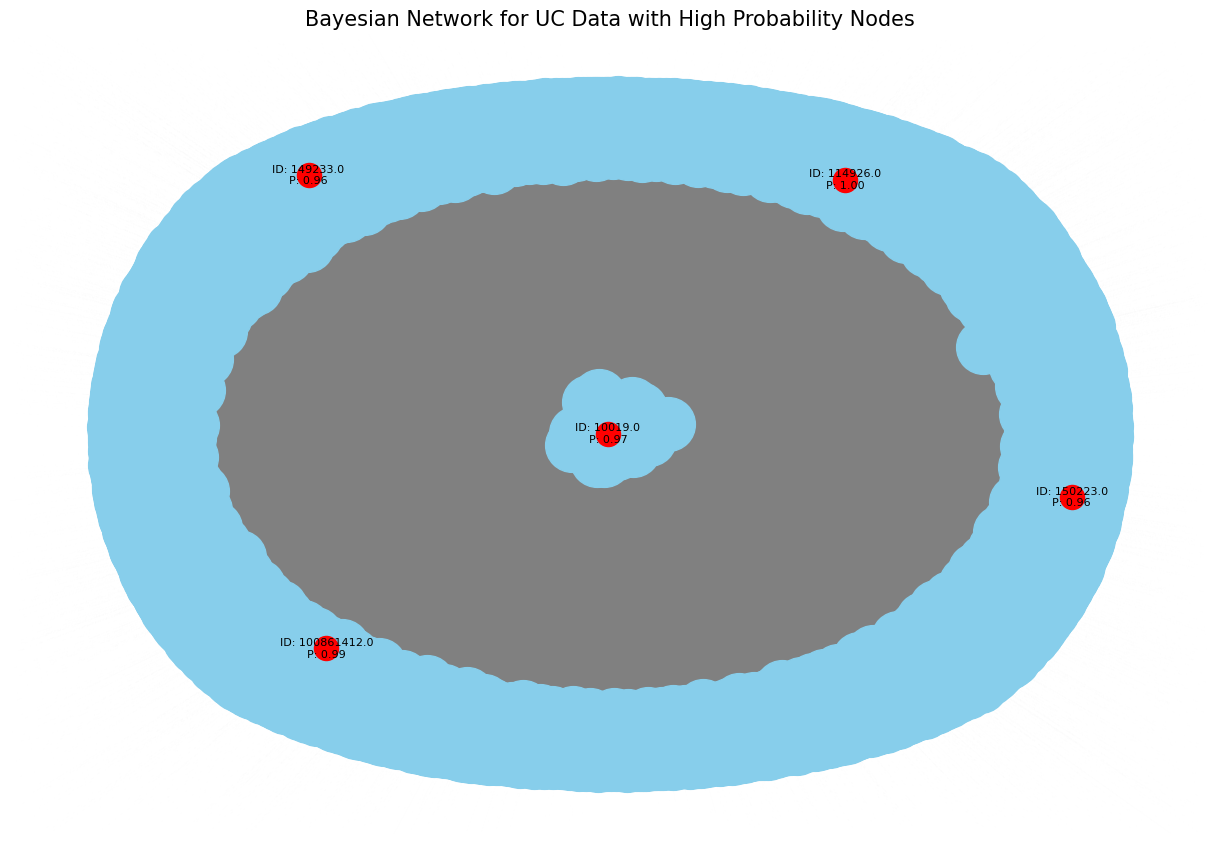

In [14]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # 节点位置
nx.draw(G, pos, with_labels= False, node_color='skyblue', node_size=1500, edge_color='gray', font_size=10, font_weight='bold')
high_prob_nodes = [node for node, data in top_nodes_by_probability]
nx.draw_networkx_nodes(G, pos, nodelist=high_prob_nodes, node_color='red')

#高概率节点
node_labels = {node: f"ID: {G.nodes[node]['Entrez_ID']}\nP: {G.nodes[node]['Probability']:.2f}" for node in high_prob_nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
plt.title("Bayesian Network for UC Data with High Probability Nodes", fontsize=15)
plt.show()

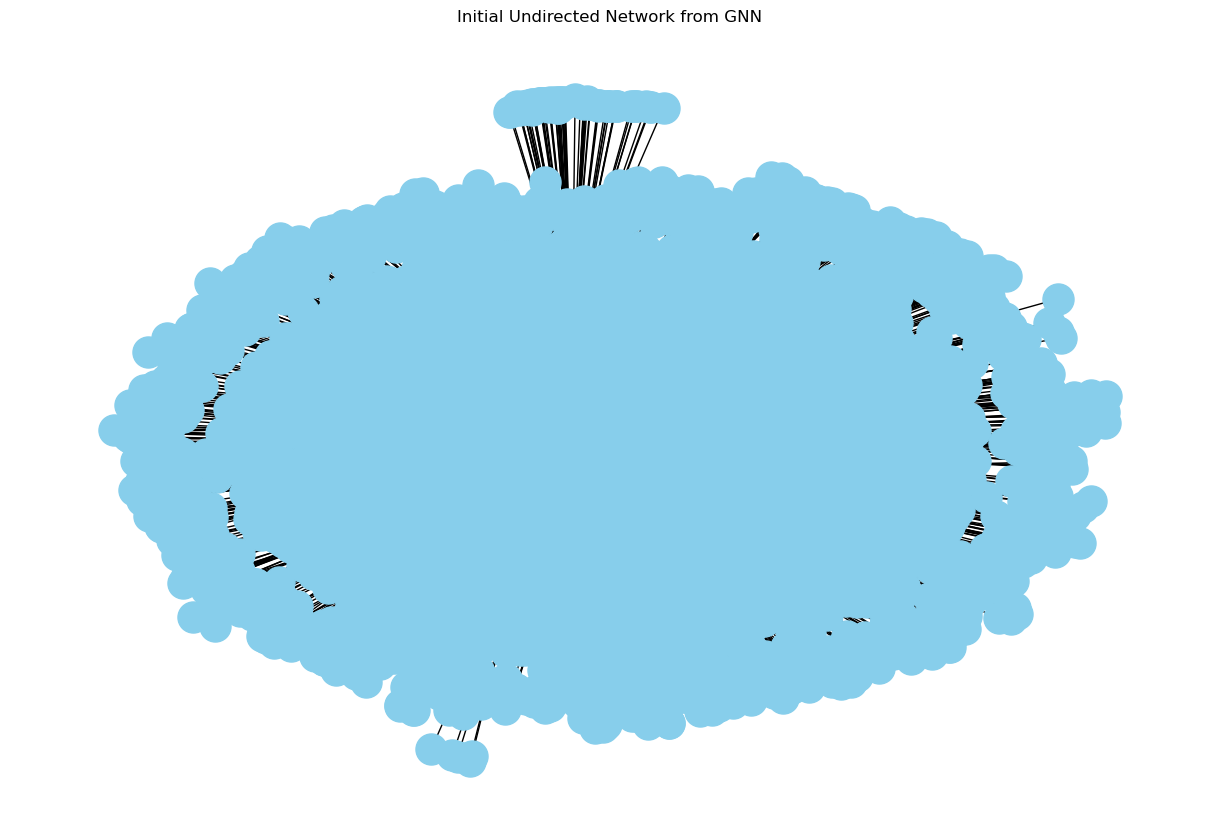

In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
edges = pd.read_csv('/Users/martinli/Desktop/SZ/edge_uc_3.txt', sep=" ", header=None, names=["From", "To"])
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['From'], row['To'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
plt.title("Initial Undirected Network from GNN")
plt.show()

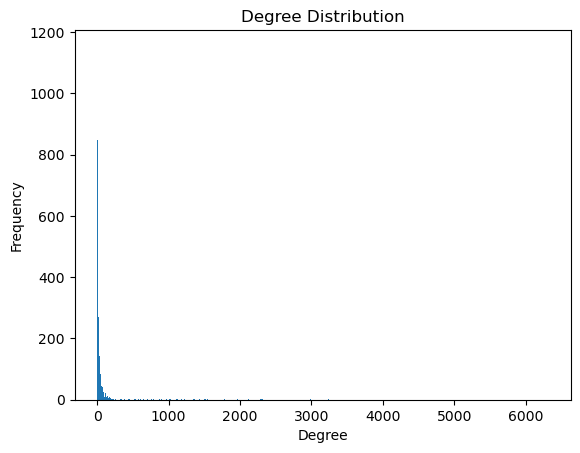

In [19]:
#节点度
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=range(1, max(degrees) + 1))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Average Clustering Coefficient: 0.4388895910636752


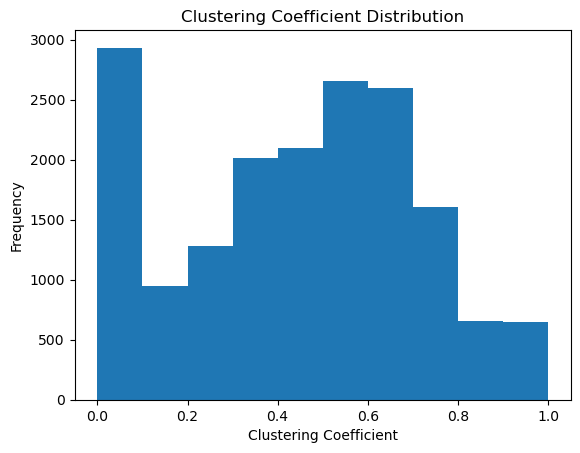

In [20]:
# 聚类系数
clustering_coeffs = nx.clustering(G)
average_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {average_clustering}")
# 聚类系数分布
plt.hist(clustering_coeffs.values())
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.show()

In [21]:
# 检查网络是否连通
if nx.is_connected(G):
    average_path_length = nx.average_shortest_path_length(G)
    print(f"Average Path Length: {average_path_length}")
else:
    print("The network is not connected, cannot compute average path length.")

Average Path Length: 2.584525717056688


In [22]:
# 度中心性
degree_centrality = nx.degree_centrality(G)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by Degree Centrality:")
for node, centrality in top_degree_centrality:
    print(f"Node: {node}, Degree Centrality: {centrality}")
# 介数中心性
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by Betweenness Centrality:")
for node, centrality in top_betweenness_centrality:
    print(f"Node: {node}, Betweenness Centrality: {centrality}")

Top 10 nodes by Degree Centrality:
Node: 1293.0, Degree Centrality: 0.3622182714916557
Node: 1405.0, Degree Centrality: 0.2926535527900442
Node: 1710.0, Degree Centrality: 0.26558467626311866
Node: 723.0, Degree Centrality: 0.2611114297184149
Node: 1605.0, Degree Centrality: 0.23151918334575902
Node: 3028.0, Degree Centrality: 0.22968400527613697
Node: 2752.0, Degree Centrality: 0.22050811492802663
Node: 2542.0, Degree Centrality: 0.21660836153007973
Node: 396.0, Degree Centrality: 0.20697367666456387
Node: 1864.0, Degree Centrality: 0.20571199174169869

Top 10 nodes by Betweenness Centrality:
Node: 1293.0, Betweenness Centrality: 0.05301214846940088
Node: 1405.0, Betweenness Centrality: 0.029571348257428794
Node: 5605.0, Betweenness Centrality: 0.027133537377919754
Node: 1710.0, Betweenness Centrality: 0.025768190801695838
Node: 1998.0, Betweenness Centrality: 0.023199163961054946
Node: 723.0, Betweenness Centrality: 0.02260650156347153
Node: 1605.0, Betweenness Centrality: 0.02078126

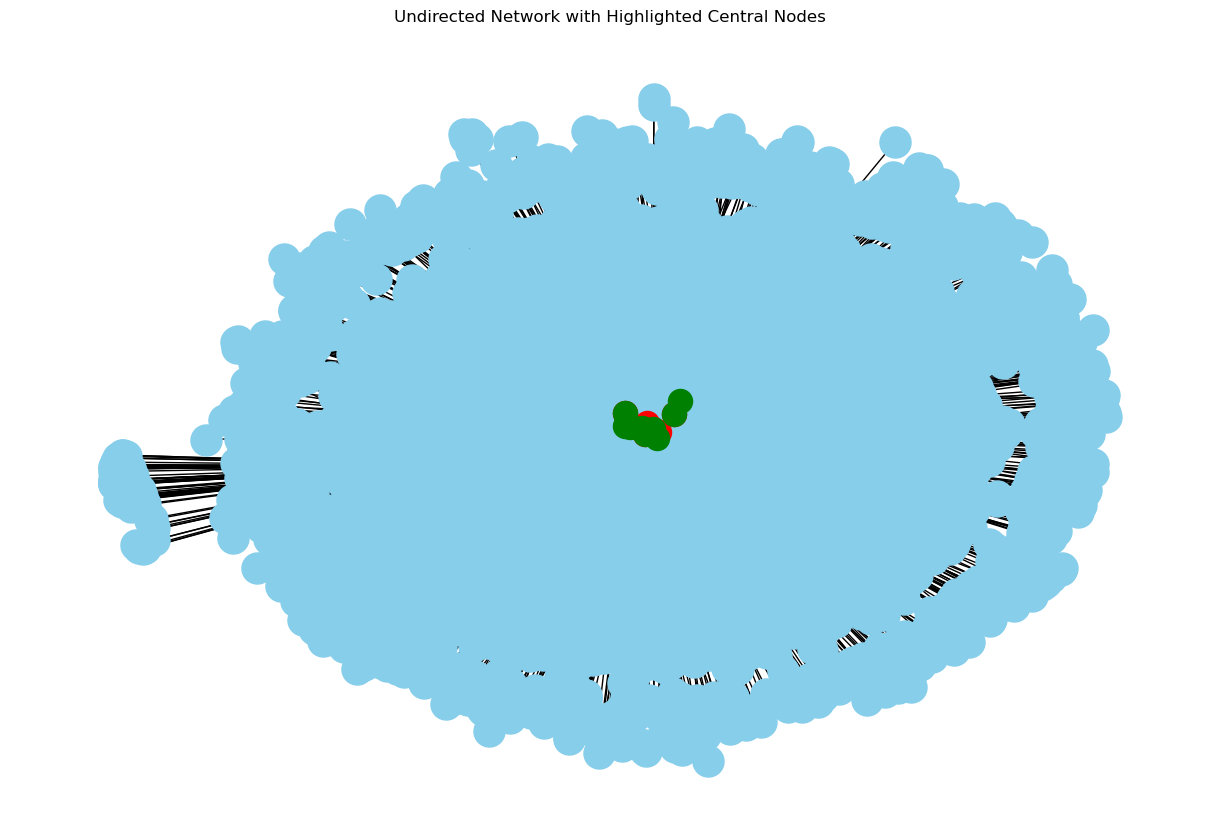

In [25]:
# 带有关键节点的网络
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
# 高亮显示度中心性最高的节点
high_degree_nodes = [node for node, centrality in top_degree_centrality]
nx.draw_networkx_nodes(G, pos, nodelist=high_degree_nodes, node_color='red')
# 高亮显示介数中心性最高的节点
high_betweenness_nodes = [node for node, centrality in top_betweenness_centrality]
nx.draw_networkx_nodes(G, pos, nodelist=high_betweenness_nodes, node_color='green')
plt.title("Undirected Network with Highlighted Central Nodes")
plt.show()

In [27]:
high_degree_nodes

[1293.0, 1405.0, 1710.0, 723.0, 1605.0, 3028.0, 2752.0, 2542.0, 396.0, 1864.0]

In [28]:
high_betweenness_nodes

[1293.0, 1405.0, 5605.0, 1710.0, 1998.0, 723.0, 1605.0, 1864.0, 175.0, 2740.0]

In [49]:
import pandas as pd
import os
import glob
import numpy as np

data_info = pd.read_csv('/Users/martinli/Desktop/SZ/data.csv')
data_path = '/Users/martinli/Desktop/SZ/GSE109142/' 

# 根据样本的特征进行分组
hc_samples_female = data_info[(data_info['Sample_Character_2'] == 'diagnosis: Control') & (data_info['Sample_Character_3'] == 'Sex: Female')]
hc_samples_male = data_info[(data_info['Sample_Character_2'] == 'diagnosis: Control') & (data_info['Sample_Character_3'] == 'Sex: Male')]
uc_samples_female = data_info[(data_info['Sample_Character_2'] == 'diagnosis: Ulcerative Colitis') & (data_info['Sample_Character_3'] == 'Sex: Female')]
uc_samples_male = data_info[(data_info['Sample_Character_2'] == 'diagnosis: Ulcerative Colitis') & (data_info['Sample_Character_3'] == 'Sex: Male')]

# 合并HC和UC组样本
hc_samples = pd.concat([hc_samples_female, hc_samples_male])
uc_samples = pd.concat([uc_samples_female, uc_samples_male])

# 显示每组样本的数量
print(f"HC samples: {len(hc_samples)}")
print(f"UC samples: {len(uc_samples)}")

# 读取TPM文件的函数
def read_tpm_file(gsm_id):
    file_pattern = f"{gsm_id}_*.txt"
    matched_files = glob.glob(os.path.join(data_path, file_pattern))
    if not matched_files:
        print(f"No files found for pattern: {file_pattern}")
        return None
    file_path = matched_files[0]  # 假设只有一个匹配文件
    df = pd.read_csv(file_path, sep="\t", header=None)
    df.columns = ['Gene', gsm_id]
    df = df.set_index('Gene')
    return df.iloc[1:]  # 跳过第一行数据

# 合并HC组样本的TPM标准化数据
hc_samples_data = []
for gsm_id in hc_samples['Sample_geo_accession']:
    sample_data = read_tpm_file(gsm_id)
    if sample_data is not None:
        hc_samples_data.append(sample_data)
    else:
        print(f"Failed to read data for GSM ID: {gsm_id}")

combined_hc_data = pd.concat(hc_samples_data, axis=1)

# 合并UC组样本的TPM标准化数据
uc_samples_data = []
for gsm_id in uc_samples['Sample_geo_accession']:
    sample_data = read_tpm_file(gsm_id)
    if sample_data is not None:
        uc_samples_data.append(sample_data)
    else:
        print(f"Failed to read data for GSM ID: {gsm_id}")

combined_uc_data = pd.concat(uc_samples_data, axis=1)

# 显示合并后的数据
print(combined_hc_data.head())
print(combined_uc_data.head())

HC samples: 20
UC samples: 202
         GSM2932807 GSM2932808 GSM2932809 GSM2932810 GSM2932811 GSM2932812  \
Gene                                                                         
5S           3.6387     1.7165     1.5406       0.01       0.01       0.01   
5              0.01       0.01       0.01       0.01       0.01       0.01   
7SK            0.01    0.92919       0.01    0.35525       0.01       0.01   
A1BG-AS1     1.2498    0.98933     0.6026    0.60026    0.41022    0.87175   
A1BG         3.2298     7.3417     5.2408     2.5553     1.6265     2.6792   

         GSM2932813 GSM2932814 GSM2932815 GSM2932816 GSM2932817 GSM2932818  \
Gene                                                                         
5S           2.2622     4.2801     5.6464     3.6585     2.4733     2.3491   
5              0.01       0.01       0.01       0.01       0.01       0.01   
7SK            0.01       0.01       0.01    0.33258       0.01       0.01   
A1BG-AS1    0.42899     0.5787  

In [48]:
import pandas as pd
import mygene

i2g_df = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df.csv', names = ['node','entrez'])
mg = mygene.MyGeneInfo()
def get_gene_name(entrez_id):
    result = mg.query(f'entrezgene:{entrez_id}', fields='symbol')
    if result['hits']:
        print("found", entrez_id, result['hits'][0]['symbol'])
        return result['hits'][0]['symbol']
    else:
        print( "no hit", entrez_id)
        return None

i2g_df['gene_name'] = i2g_df['entrez'].apply(get_gene_name)
print(i2g_df.head())
i2g_df.to_csv('/Users/martinli/Desktop/SZ/i2g_df_with_gene_name.csv', index=False)

no hit 0
found 381 ARF5
found 805 CALM2
found 23229 ARHGEF9
found 2081 ERN1
found 1029 CDKN2A
found 5034 P4HB
found 8677 STX10
found 59345 GNB4
found 3800 KIF5C
found 2618 GART
found 22908 SACM1L
found 27352 SGSM3
found 92344 GORAB
found 27031 NPHP3
found 1612 DAPK1
found 9263 STK17A
found 6712 SPTBN2
found 23303 KIF13B
found 11069 RAPGEF4
found 65975 STK33
found 7041 TGFB1I1
found 9771 RAPGEF5
found 162 AP1B1
found 11234 HPS5
found 27237 ARHGEF16
found 197135 PATL2
found 93664 CADPS2
found 10746 MAP3K2
found 79861 TUBAL3
found 2774 GNAL
found 998 CDC42
found 6098 ROS1
found 54737 MPHOSPH8
found 23163 GGA3
found 4593 MUSK
found 57568 SIPA1L2
found 79735 TBC1D17
found 163 AP2B1
found 55605 KIF21A
found 28996 HIPK2
found 203286 ANKS6
found 11329 STK38
found 26984 SEC22A
found 140462 ASB9
found 56929 FEM1C
found 146691 TOM1L2
found 54434 SSH1
found 2180 ACSL1
found 5531 PPP4C
found 347733 TUBB2B
found 51014 TMED7
found 25972 UNC50
found 51209 RAB9B
found 83988 NCALD
found 56950 SMYD2
foun

In [1]:
import pandas as pd
i2g_df_gene_symbol = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df_gene_symbol.csv')
initial_nodes_df = pd.read_csv('/Users/martinli/Desktop/SZ/initial_nodes.txt', sep=" ", header=None, names=['from', 'to'])
ppion = pd.read_csv('/Users/martinli/Desktop/SZ/ppionly_uc_newresults.csv')
ppion_nodes = ppion['node id']
# Combine
initial_nodes = set(initial_nodes_df['from']).union(set(initial_nodes_df['to']))
i2g_df_gene_symbol['initial'] = i2g_df_gene_symbol['node'].apply(lambda x: x in initial_nodes)
i2g_df_gene_symbol.head()


,node,entrez,gene_name,initial
0,0.0,381,ARF5,True
1,1.0,805,CALM2,True
2,2.0,23229,ARHGEF9,True
3,3.0,2081,ERN1,True
4,4.0,1029,CDKN2A,True


In [8]:
i2g_df_gene_symbol_jul25 = i2g_df_gene_symbol[i2g_df_gene_symbol["initial"] == True]
i2g_df_gene_symbol_jul25.to_csv('/Users/martinli/Desktop/SZ/i2g_df_gene_symbol_jul25.csv')

In [ ]:
i2g_df_gene_symbol['ppion'] = i2g_df_gene_symbol['node'].apply(lambda x: x in ppion_nodes)
i2g_df_gene_symbol.head()
i2g_df_gene_symbol.to_csv('/Users/martinli/Desktop/SZ/i2g_df_gene_ppion.csv', index=False)